<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/08-object-detection/01_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Image segmentation

Image segmentation is a simple approach to finding objects in an image. Image segmentation
is a classification problem, but instead of classifying the whole image, we classify every pixel. So a `200 x 200` image will have
`200 x 200 = 40000` classifications. The classes in image segmentation tasks are usually
different kinds of objects we could detect.

The goal is to produce the ground truth, where every pixel is classified as belonging to
either a person, a horse, a car, or the background. We have a classification problem
with four unique classes; it just happens to be that a single input involves making many
predictions. So if we have a `128 x 128` image, we have $128^2 = 16 384$ classifications to
perform.

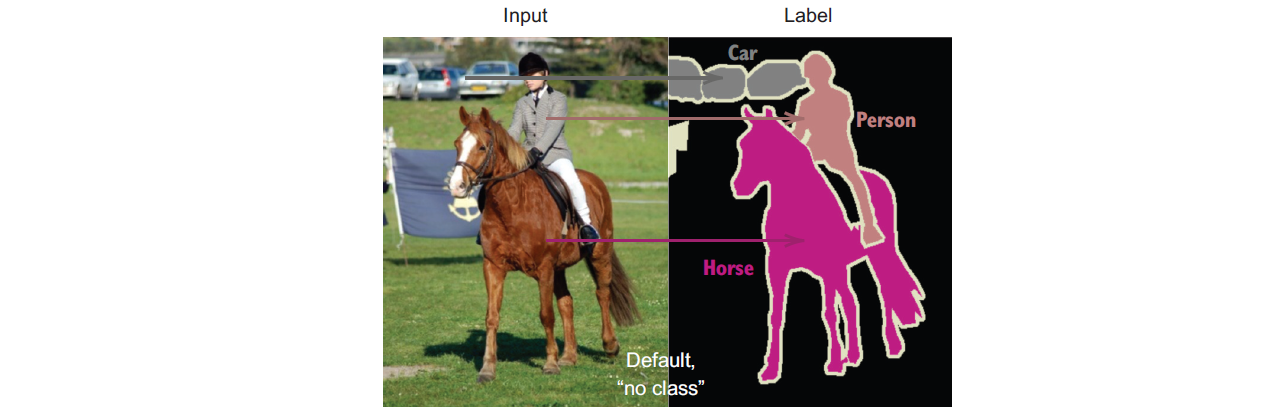

The task of image segmentation is a great opportunity to use a convolutional neural
network. A CNN is designed to produce local outputs for a local region of the input.

So our strategy for designing an image segmentation network will use convolutional
layers as the output layer, too, instead of an nn.Linear layer as we did before. 

When we
design a network that contains only convolutional layers (in addition to nonlinearity
and normalization layers), we call that network fully convolutional.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We will use data from the 2018 Data
Science Bowl (https://www.kaggle.com/c/data-science-bowl-2018). 

The goal of this competition was to detect nuclei of cells and their respective sizes. But we will just
segment the image for now.

In [7]:
!mkdir data
!mkdir stage1_train

In [8]:
data_url_zip = "https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/data/stage1_train.zip?raw=true"

# Download this dataset if we have not already done so
if not os.path.isdir("./data/stage1_train"):
  response = urlopen(data_url_zip)
  os.mkdir("./data/stage1_train")
  zipfile = ZipFile(BytesIO(response.read()))
  zipfile.extractall(path="./data/stage1_train")

# Grab all the paths to the images we just unziped 
paths = glob("./data/stage1_train/*")

Next we create 2018 Data Science Bowl dataset.

In [10]:
class Bowl2018Dataset(Dataset):
  """
  Dataset class for the 2018 Data Science Bowl.
  """
  def __init__(self, paths):
    """
    paths: a list of paths to every image folder in the dataset
    """
    self.paths = paths

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    # There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
    img_path = glob(self.paths[idx] + "/images/*")[0]
    # but there are multiple mask images in each mask path
    mask_imgs = glob(self.paths[idx] + "/masks/*")
    # the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
    img = imread(img_path)[:, :, 0:3]  # trim off the alpha so we get (W, H, 3)
    # Now we want this as (3, W, H), which is the normal shape for PyTorch
    img = np.moveaxis(img, -1, 0)
    # Last step for the image, re-scale it to the range [0, 1]
    img = img / 255.0

    # Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background
    masks = [imread(f) / 255.0 for f in mask_imgs]

    # Since we want to do simple segmentation, we will create one final mask that contains _all_ nuclei pixels from _every_ mask
    final_mask = np.zeros(masks[0].shape)
    for m in masks:
      final_mask = np.logical_or(final_mask, m)
    final_mask = final_mask.astype(np.float32)

    # Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
    img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) # First we convert to PyTorch tensors
    # The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
    img = F.interpolate(img.unsqueeze(0), (256, 256))
    final_mask = F.interpolate(final_mask.unsqueeze(0), (256, 256))
    # Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". 
    # This will return a tuple of: (3, 256, 256), (1, 256, 256)
    return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]

Now that we can load the dataset, let’s visualize some of the data .

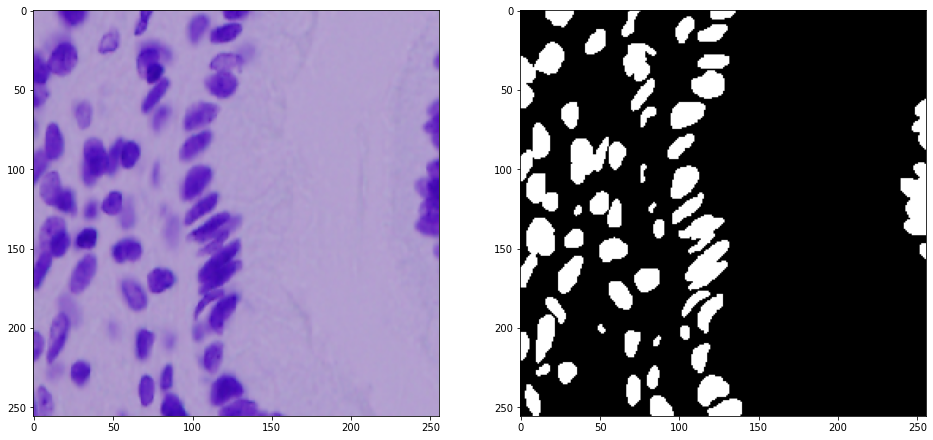

In [11]:
# Create the Dataset class object
dsb_data = Bowl2018Dataset(paths)

plt.figure(figsize=(16, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1, 2, 0).numpy())

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0, :], cmap="gray")

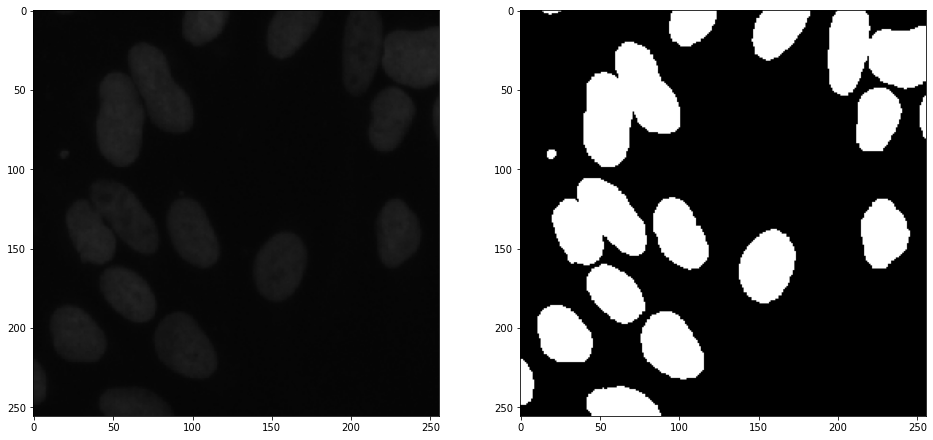

In [12]:
# Lets plot a second image that is in color
plt.figure(figsize=(16, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[1][0].permute(1, 2, 0).numpy())

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[1][1].numpy()[0, :], cmap="gray")